In [1]:
# df.resample('M').mean()

# Data Dictionary

|Feature|Type|Description|
|---|---|---|
|Product_Code|*string*|The product name encoded|
|Warehouse|*string*|Warehouse ID|
|Product_Category|*string*|Product category of each product|
|Date|*string*|The date customer needs the product|
|Order_Demand|*string*|Order quantity|

In [2]:
# Import libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.metrics import RSquare
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Read csv file and display shape.
df = pd.read_csv('../Data_Historical/df2.csv').iloc[:,1:]
df.shape

(924272, 5)

In [4]:
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0965,Whse_A,Category_006,2011-01-08,2
1,Product_1724,Whse_A,Category_003,2011-05-31,108
2,Product_1521,Whse_S,Category_019,2011-06-24,85000
3,Product_1521,Whse_S,Category_019,2011-06-24,7000
4,Product_1507,Whse_C,Category_019,2011-09-02,1250


df_init = df[df['Product_Code']==code]
    df_init['Date'] = pd.to_datetime(df_init['Date'])
    df_init = df_init.set_index('Date')
    df_init = pd.DataFrame((df_init['Order_Demand']).resample('W').sum())
    df_init.rename(columns={'Order_Demand':code},inplace=True)
    all_cat_019 = pd.concat([all_cat_019,df_init],axis=1)

In [5]:
tf.random.set_seed(7)

In [6]:
# Queries all rows of Product 1359.
df_1359 = df[df['Product_Code']=='Product_1359']

# Convert Date to datetime format.
df_1359['Date'] = pd.to_datetime(df_1359['Date'])

# Set Date as index.
df_1359 = df_1359.set_index('Date')

# Resample Order Demand of Product 1359 to weekly sales in the multiple of 1000.
prod_1359 = pd.DataFrame((df_1359['Order_Demand']/1000).resample('W').sum())
prod_1359.rename(columns={'Order_Demand':'demand'}, inplace=True)

C:\Users\Zeonice\AppData\Local\Temp\ipykernel_3280\1070879320.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1359['Date'] = pd.to_datetime(df_1359['Date'])


In [7]:
prod_1359.shape

(262, 1)

In [8]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
 df = pd.DataFrame(data)
 columns = [df.shift(i) for i in range(1, lag+1)]
 columns.append(df)
 df = pd.concat(columns, axis=1)
 df = df.drop(0)
 return df

# create a differenced series
def difference(dataset, interval=1):
 diff = list()
 for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
 return pd.Series(diff)

# scale train and test data to [-1, 1]
def scale(train, test):
 # fit scaler
 scaler = MinMaxScaler(feature_range=(-1, 1))
 scaler = scaler.fit(train)
 # transform train
 train = train.reshape(train.shape[0], train.shape[1])
 train_scaled = scaler.transform(train)
 # transform test
 test = test.reshape(test.shape[0], test.shape[1])
 test_scaled = scaler.transform(test)
 return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
 new_row = [x for x in X] + [yhat]
 array = np.array(new_row)
 array = array.reshape(1, len(array))
 inverted = scaler.inverse_transform(array)
 return inverted[0, -1]

# evaluate the model on a dataset, returns RMSE in transformed units
def evaluate(model, raw_data, scaled_dataset, scaler, offset, batch_size):
 # separate
 X, y = scaled_dataset[:,0:-1], scaled_dataset[:,-1]
 # reshape
 reshaped = X.reshape(len(X), 1, 1)
 # forecast dataset
 output = model.predict(reshaped, batch_size=batch_size)
 # invert data transforms on forecast
 predictions = list()
 for i in range(len(output)):
    yhat = output[i,0]
 # invert scaling
    yhat = invert_scale(scaler, X[i], yhat)
 # invert differencing
    yhat = yhat + raw_data[i]
 # store forecast
    predictions.append(yhat)
 # report performance
 rmse = np.sqrt(mean_squared_error(raw_data[1:], predictions))
 return rmse

In [19]:
# fit an LSTM network to training data
def fit_lstm(train, test, raw, scaler, batch_size, nb_epoch, neurons):
 X, y = train[:, 0:-1], train[:, -1]
 X = X.reshape(X.shape[0], 1, X.shape[1])
 # prepare model
 model = Sequential()
 model.add(LSTM(neurons, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
 model.add(LSTM(neurons,activation='relu'))
 model.add(Dense(1))
 model.compile(loss='mean_squared_error', optimizer='adam')
 # fit model
 train_rmse, test_rmse = list(), list()
 for i in range(nb_epoch):
    model.fit(X, y, epochs=i, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()
 # evaluate model on train data
    raw_train = raw[-(len(train)+len(test)+1):-len(test)]
    train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
    model.reset_states()
 # evaluate model on test data
    raw_test = raw[-(len(test)+1):]
    test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
    model.reset_states()
    history = pd.DataFrame()
    history['train'], history['test'] = train_rmse, test_rmse
 return history

In [10]:
def run():
 # load dataset
 # series = pd.read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
 # transform data to be stationary
 raw_values = prod_1359.values
 diff_values = difference(raw_values, 1)
 # transform data to be supervised learning
 supervised = timeseries_to_supervised(diff_values, 1)
 supervised_values = supervised.values
 # split data into train and test-sets
 train, test = supervised_values[0:-12], supervised_values[-12:]
 # transform the scale of the data
 scaler, train_scaled, test_scaled = scale(train, test)
 # fit and evaluate model
 train_trimmed = train_scaled[2:, :]
 # config
 repeats = 1
 n_batch = 1
 n_epochs = 2
 n_neurons = 1
 # run diagnostic tests
 for i in range(repeats):
    history = fit_lstm(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
    pyplot.plot(history['train'], color='blue')
    pyplot.plot(history['test'], color='orange')
    print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))
pyplot.savefig('epochs_diagnostic.png')

<Figure size 640x480 with 0 Axes>

In [11]:
raw_values = prod_1359.values
diff_values = difference(raw_values, 1)
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
train, test = supervised_values[0:-4], supervised_values[-4:]
scaler, train_scaled, test_scaled = scale(train, test)
train_trimmed = train_scaled[2:, :]
 

1/1 [==============================] - 0s 25ms/step
0) TrainRMSE=798.394533, TestRMSE=612.411736


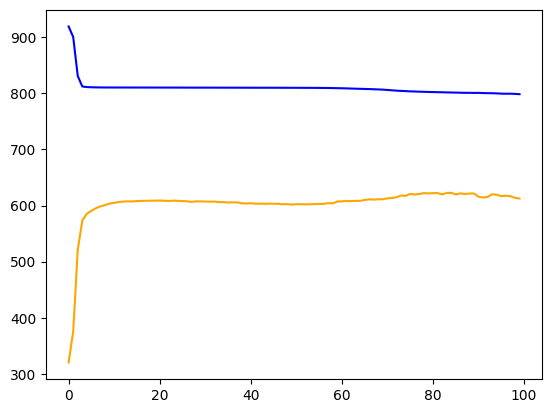

In [21]:
repeats = 1
n_batch = 4
n_epochs = 100
n_neurons = 30
n_steps = 1
n_features = 1
# run diagnostic tests
for i in range(repeats):
    history = fit_lstm(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
    pyplot.plot(history['train'], color='blue')
    pyplot.plot(history['test'], color='orange')
    print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))

In [13]:
batch_size = 4
neurons = 1
n_steps =1
n_features = 1

In [61]:
# fit an LSTM network to training data
#def fit_lstm(train, test, raw, scaler, batch_size, nb_epoch, neurons):
X, y = train_scaled[:, 0:-1], train[:, -1]
X = X.reshape(X.shape[0], 1, X.shape[1])
# prepare model
model = Sequential()
model.add(LSTM(neurons, input_shape=(n_steps, n_features))) #, batch_input_shape=(batch_size, X.shape[1], X.shape[2])
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
"""
 

 # fit model
 train_rmse, test_rmse = list(), list()
 for i in range(nb_epoch):
    model.fit(X, y, epochs=i, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()
 # evaluate model on train data
    raw_train = raw[-(len(train)+len(test)+1):-len(test)]
    train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
    model.reset_states()
 # evaluate model on test data
    raw_test = raw[-(len(test)+1):]
    test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
    model.reset_states()
    history = pd.DataFrame()
    history['train'], history['test'] = train_rmse, test_rmse
 return history
"""


"\n \n\n # fit model\n train_rmse, test_rmse = list(), list()\n for i in range(nb_epoch):\n    model.fit(X, y, epochs=i, batch_size=batch_size, verbose=0, shuffle=False)\n    model.reset_states()\n # evaluate model on train data\n    raw_train = raw[-(len(train)+len(test)+1):-len(test)]\n    train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))\n    model.reset_states()\n # evaluate model on test data\n    raw_test = raw[-(len(test)+1):]\n    test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))\n    model.reset_states()\n    history = pd.DataFrame()\n    history['train'], history['test'] = train_rmse, test_rmse\n return history\n"

In [17]:
model.predict(X)

NameError: name 'model' is not defined

In [57]:
y.shape

(258,)